# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from prettytable import PrettyTable

C:\Users\sirsh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(os.getcwd()+'/Assignment/database.sqlite')

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = filtered_data["Score"].map(partition)
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible. Hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

## [2.4] Upsampling the data for a balanced dataset

In [10]:
final_neg = final[final.Score==0]
final_neg_upsampled = resample(final_neg, replace=True, n_samples=38000, random_state=1)

In [11]:
final = pd.concat([final[final.Score==1], final_neg_upsampled])
final.shape

(90600, 10)

## [2.5] Sorting the data according to Time

In [12]:
final = final.sort_values(by="Time", ascending=True).reset_index(drop=True)

In [13]:
#Verifying the data
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
2,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
3,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
4,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan..."


In [14]:
final.tail(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
90595,24518,B0016JJEFG,AO9WE22147CRH,Arvind Rajan,0,0,0,1351209600,bad tasting tea,We drink a lot of tea... from all over the wor...
90596,27424,B003WEFSAI,A37O0JPLJ8BOXP,Texaschick59,0,0,1,1351209600,Drink mix,We love this drink mix it taste delicious and ...
90597,73819,B008AHJZWY,AL0PVH6QPNWMW,good151,0,0,0,1351209600,Hint Fizz,I love hint water so when I saw they offered h...
90598,33768,B002ESVRWQ,A293T21WVQ3TDC,"James E. Palmiter ""Bargin Hunter""",0,0,0,1351209600,A bit weak...,"The coffee ""Blend"" is really lean on Kona and ..."
90599,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,0,1351209600,Don't like the taste,I do not like sour taste and this has a sour k...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
from bs4 import BeautifulSoup

def cleanhtml(dirtytext):
    return BeautifulSoup(dirtytext, "html.parser").get_text()

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
#Storing the stopwords of english
stopwords = set(nltk.corpus.stopwords.words("english"))
# stopwords

In [18]:
#function to remove stopwords, removing alphaneumeric words and lowering caps
def secondClean(text):
    filtered_words = []
    text = re.sub('[^A-Za-z]+', ' ', text)
    for x in text.split():
        if x not in stopwords and x.isalpha():
            filtered_words.append(x.lower())
    return " ".join(filtered_words).strip()

In [19]:
#Testing function:
x = cleanhtml("<div><a>XYZZYSPOON!</a></div>")
print(x)
print(secondClean("[Auld] [Lang Syne"))

XYZZYSPOON!
auld lang syne


In [20]:
#Preprocessing the reviews
final["CleanedText"] = final["Text"].apply(lambda x:cleanhtml(x))
final["CleanedText"] = final["CleanedText"].apply(lambda x: decontracted(x))
final["CleanedText"] = final["CleanedText"].apply(lambda x: secondClean(x))

In [21]:
final["CleanedText"].values[0]

'this really good idea final product outstanding i use decals car window everybody asks bought decals made two thumbs'

In [22]:
final["Text"].values[0]

'This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!'

# [4] Applying Logistic Regression

### General functions for smooth sailing

In [23]:
from sklearn.linear_model import LogisticRegression

In [40]:
def imp_features(feature_names, classifier, label, n=10):
#     class_labels=classifier.classes_
    if label==1:
        topn_class = sorted(zip(classifier.coef_[0], feature_names),reverse=True)[:n]
    if label==0:
        topn_class = sorted(zip(classifier.coef_[0], feature_names),reverse=False)[:n]
    x = PrettyTable()
    x.field_names = ["Coefficient", "Feature Name"]
    for coef, feature in topn_class:
        x.add_row([coef, feature])
    print(x)

In [25]:
def get_best_hyperparam(X_train, X_test, y_train, y_test, pen="l1"):
    clf_score = []
    iterator = np.linspace(0.001, 1000, 50)
    for hyper in tqdm(iterator):
        clf = LogisticRegression(penalty=pen, C=hyper)
        clf.fit(X_train, y_train)
        train_pred_proba = clf.predict_proba(X_train)[:,1]
        test_pred_proba = clf.predict_proba(X_test)[:,1]
        roc_auc_test =roc_auc_score(y_test, test_pred_proba)
        roc_auc_train =roc_auc_score(y_train, train_pred_proba)
        clf_score.append([hyper, roc_auc_train, roc_auc_test])
    highest_acc = max(clf_score, key=lambda x:x[2])
    best_c = highest_acc[0]
    sns.lineplot([x[0] for x in clf_score], [x[1] for x in clf_score], \
             color ="blue", label="Training AUC")
    sns.scatterplot([x[0] for x in clf_score], [x[1] for x in clf_score], \
                 color ="red")
    sns.lineplot([x[0] for x in clf_score], [x[2] for x in clf_score], \
                 color ="red", label="Testing AUC")
    sns.scatterplot([x[0] for x in clf_score], [x[2] for x in clf_score], \
                 color ="blue")
    plt.xlabel("Hyperparameter C")
    plt.ylabel("AUC")
    plt.title("C vs ROC_AUC")
    plt.xscale("log")
    plt.legend()
    plt.show()
    
    generate_confusion(best_c, X_train, X_test, y_train, y_test, pen)

    f_auc = generate_roc(clf, X_train, X_test, y_train, y_test, best_c)
    return best_c, f_auc

In [26]:
def generate_roc(clf, X_train, X_test, y_train, y_test, best_c):
    
    y_train_pred_proba = clf.predict_log_proba(X_train)[:,1]
    fpr_train, tpr_train, thres_train = roc_curve(y_train, y_train_pred_proba)
    y_pred_proba = clf.predict_log_proba(X_test)[:,1]
    fpr, tpr, thres = roc_curve(y_test, y_pred_proba)
    ra_s =roc_auc_score(y_test,y_pred_proba)
    ra_tr =roc_auc_score(y_train, y_train_pred_proba)
    plt.plot([0,1],[0,1],'k--', label="Dummy Model")
    plt.plot(fpr_train,tpr_train, 'b', label=f'Training Curve = {ra_tr}')
    plt.plot(fpr,tpr, 'r', label=f'Testing AUC = {ra_s}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f"C = {best_c} ROC curve")
    plt.legend()
    plt.show()
    
    return ra_s    

In [27]:
def generate_confusion(best_c, X_train, X_test, y_train, y_test, pen="l1"):
    clf = LogisticRegression(C=best_c, penalty=pen)
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    cm = confusion_matrix(y_train, train_pred)
    labels = ['0', '1']
    df_cm = pd.DataFrame(cm, index = labels, columns = labels)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix for Training Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()
    
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    labels = ['0', '1']
    df_cm = pd.DataFrame(cm, index = labels, columns = labels)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix for Test Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()
    return

In [28]:
#Splitting the dataset into train_test
from sklearn.model_selection import train_test_split

X = final["CleanedText"].values
y = final["Score"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## [4.1] Applying Logistic Regression with BOW

In [29]:
#Creating a bow instance
bow = CountVectorizer(ngram_range=(1,2))
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

### [4.1.1] Finding the optimal C for BOW with L1

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:59<00:00,  5.44s/it]


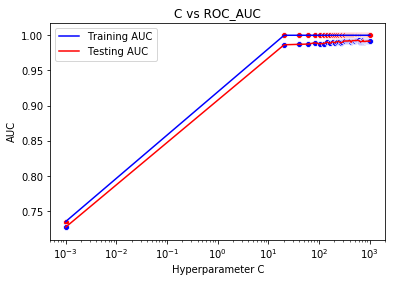

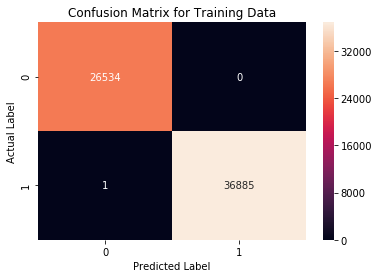

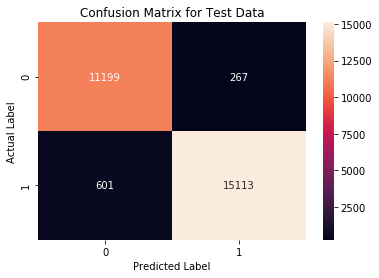

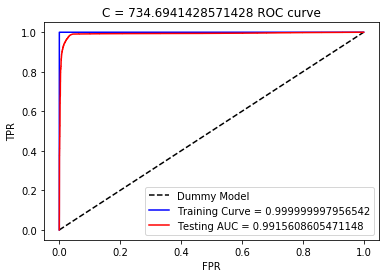

Wall time: 4min 4s


In [30]:
%%time
l1_bow_c, l1_bow_auc = get_best_hyperparam(X_train_bow, X_test_bow, y_train, y_test)

### [4.1.2] Perturbation test on BOW

In [31]:
mean, s = 0, 1
pert_X_train = X_train_bow
epsilon = np.random.normal(mean, s, size = (pert_X_train[np.nonzero(pert_X_train)].size))
pert_X_train[np.nonzero(pert_X_train)] = pert_X_train[np.nonzero(pert_X_train)] + epsilon

In [32]:
lr = LogisticRegression(penalty="l1", C = l1_bow_c)
lr.fit(X_train_bow, y_train)
bow_score = lr.score(X_test_bow, y_test)

cf = lr.coef_[0]
w1_coef = cf[np.nonzero(cf)]

lr_p = LogisticRegression(penalty="l1", C = l1_bow_c)
lr_p.fit(pert_X_train, y_train)
pert_bow_score = lr_p.score(X_test_bow, y_test)

cf = lr_p.coef_[0]
w2_coef = cf[np.nonzero(cf)]

In [33]:
all_feat = {}
for k,v in zip(lr.coef_[0], bow.get_feature_names()):
    all_feat[k] = v

#### 20 features with percentage change higher than threshold

In [34]:
#finding the percentage change vector
pcv = []
for w1, w2 in zip(w1_coef, w2_coef):
    diff = abs(w1 - w2)/abs(w1)*100
    if diff>2.5:
        pcv.append(all_feat[w1])
print(pcv[:20])

['aahing coffee', 'aasanfood com', 'abandoned buried', 'abdominal distress', 'abhor wasting', 'ability', 'ability rate', 'ablaze quite', 'able', 'able available', 'able buy', 'able drink', 'able eat', 'able escape', 'able find', 'able fix', 'able give', 'able make', 'able offer', 'able order']


#### Sparsity of weight vector in L1 norm

In [35]:
non_zero = np.count_nonzero(lr.coef_)
total_val = np.product(lr.coef_.shape)
sparsity = (total_val - non_zero) / total_val
print(sparsity)

0.9456502324157201


### [4.1.3] Finding the optimal C with L2 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [28:04<00:00, 22.44s/it]


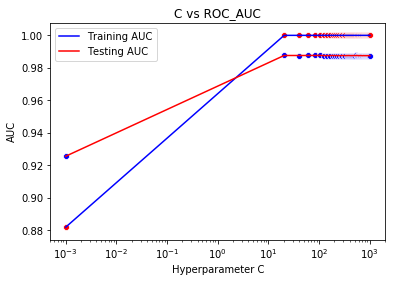

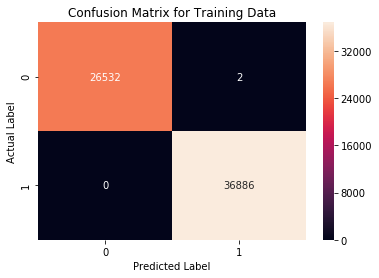

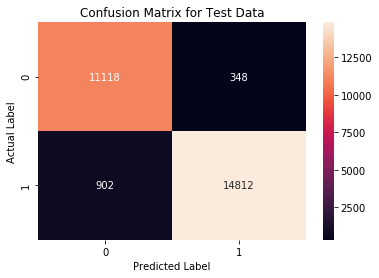

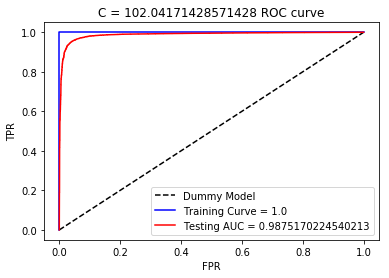

Wall time: 28min 28s


In [36]:
%%time
l2_bow_c, l2_bow_auc = get_best_hyperparam(X_train_bow, X_test_bow, y_train, y_test, pen="l2")

### [4.1.4] Feature importance

#### Top 10 features of negative class

In [41]:
imp_features(bow.get_feature_names(), lr, label=0, n=10)

+---------------------+-----------------+
|     Coefficient     |   Feature Name  |
+---------------------+-----------------+
|  -13.06528327359252 | less pronounced |
| -12.783804854847943 |  sugar quality  |
| -12.301065709869226 |    haribo way   |
| -11.547665927015373 |    meh think    |
| -11.456908700369175 |  flavors sickly |
| -11.440744050843989 |      lbs my     |
| -11.173679337832294 |      lb yr      |
| -10.902623049179455 |   suggest one   |
| -10.420095108826468 |  was expecting  |
| -10.300733943111148 |  davidsons far  |
+---------------------+-----------------+


#### Top 10 features of positive class

In [42]:
imp_features(bow.get_feature_names(), lr, label=1, n=10)

+--------------------+-----------------+
|    Coefficient     |   Feature Name  |
+--------------------+-----------------+
| 11.868792478262623 |     rope jar    |
| 9.774653503369155  |   would giving  |
| 9.216070537110179  |   boxer chewed  |
| 8.762119826917468  |    dill sauce   |
| 8.078007091874396  |   kitten loves  |
| 8.040859467290204  |  beautiful item |
| 7.690015783433135  |     less bag    |
| 7.6345715477973615 |   online half   |
|  7.5227180814637   | product looking |
| 7.4674271978228255 |  around dollars |
+--------------------+-----------------+


## [4.2] Applying Logistic Regression with tf-idf

In [43]:
%%time
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf_idf = tf_idf.fit_transform(X_train)
X_test_tf_idf = tf_idf.transform(X_test)

Wall time: 8.7 s


### [4.2.1] Finding the optimal C for tf-idf with L1

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.20s/it]


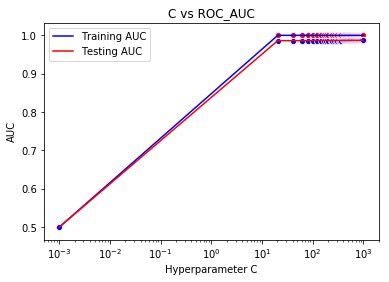

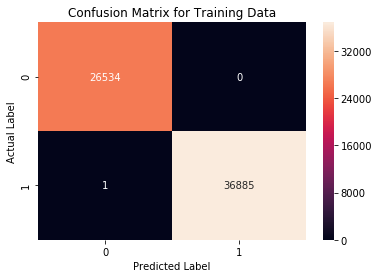

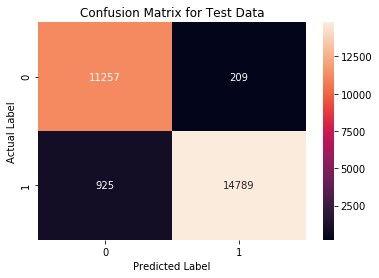

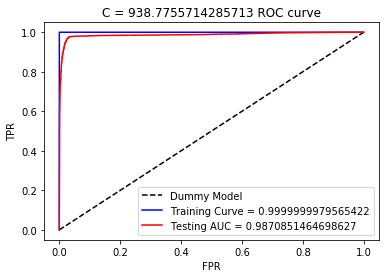

Wall time: 1min 11s


In [44]:
%%time
l1_tfidf_c, l1_tfidf_auc = get_best_hyperparam(X_train_tf_idf, X_test_tf_idf, y_train, y_test)

### [4.2.3] Finding the optimal C for tfidf with L2

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:01<00:00,  2.24s/it]


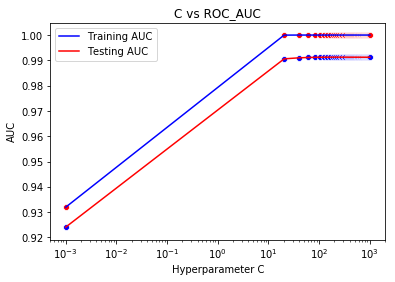

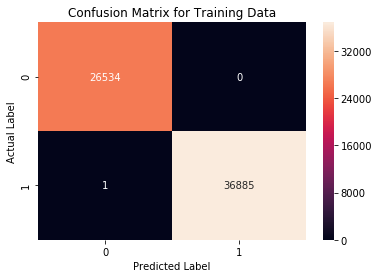

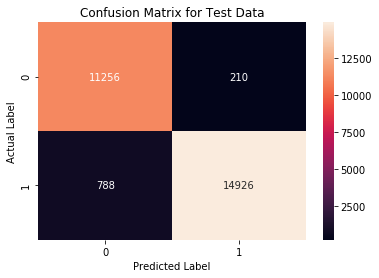

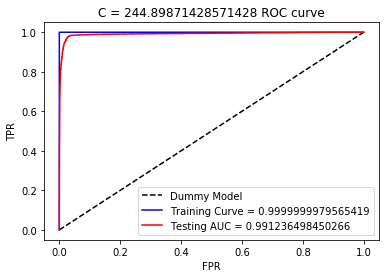

Wall time: 2min 5s


In [45]:
%%time
l2_tfidf_c, l2_tfidf_auc = get_best_hyperparam(X_train_tf_idf, X_test_tf_idf, y_train, y_test, pen="l2")

### [4.2.3] Feature importance

#### Top 10 features of negative class

In [46]:
imp_features(tf_idf.get_feature_names(), lr, label=0, n=10)

+--------------------+----------------+
|    Coefficient     |  Feature Name  |
+--------------------+----------------+
| -8.574626353608297 |   smokehouse   |
| -8.461294308756786 |   five year    |
| -8.35781371383393  |  they exactly  |
| -8.345656189081863 |   teeth hurt   |
| -8.018805372148059 |    top bag     |
| -7.95913701028052  |   this looks   |
| -7.774626291359258 |    it seem     |
| -7.243190380325081 | eat vegetables |
| -7.213990571018203 |  may product   |
| -7.174340927043099 | forgot mention |
+--------------------+----------------+


#### Top 10 features of positive class

In [47]:
imp_features(tf_idf.get_feature_names(), lr, label=1, n=10)

+--------------------+-----------------+
|    Coefficient     |   Feature Name  |
+--------------------+-----------------+
| 7.4674271978228255 |    think tea    |
| 5.947441490253848  |  would happened |
| 5.814341271144911  |    also liked   |
| 5.637696907476729  |      saucer     |
| 5.633836953962442  |    jumbo size   |
| 5.305375549079467  |  pretty strong  |
| 5.265662743542031  |      teabag     |
| 5.157586603235586  |    the green    |
| 5.045841010650925  |    the sugar    |
| 5.005618475110167  | also appreciate |
+--------------------+-----------------+


## [4.3] Applying Logistic Regression with avg_w2v

In [48]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [49]:
def compute_avgw2v(list_of_reviews, w2v_model):
    w2v_words = list(w2v_model.wv.vocab)
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_reviews): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [50]:
# Train your own Word2Vec model using your own text corpus for train data
i=0
list_of_reviews_train=[]
for review in X_train_w2v:
    list_of_reviews_train.append(review.split())

w2v_model=Word2Vec(list_of_reviews_train,min_count=5,size=50, workers=4)

X_train_aw2v = compute_avgw2v(list_of_reviews_train, w2v_model)

100%|███████████████████████████████████████████████████████████████████████████| 63420/63420 [01:24<00:00, 754.17it/s]


63420
50


In [51]:
# Train your own Word2Vec model using your own text corpus for test data
i=0
list_of_reviews_test=[]
for review in X_test_w2v:
    list_of_reviews_test.append(review.split())

# w2v_model=Word2Vec(list_of_reviews_test,min_count=5,size=50, workers=4)
X_test_aw2v = compute_avgw2v(list_of_reviews_test, w2v_model)

100%|███████████████████████████████████████████████████████████████████████████| 27180/27180 [00:38<00:00, 708.41it/s]


27180
50


### [4.3.1] Finding optimal C using Avg_w2v with L1

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:19<00:00,  9.00s/it]


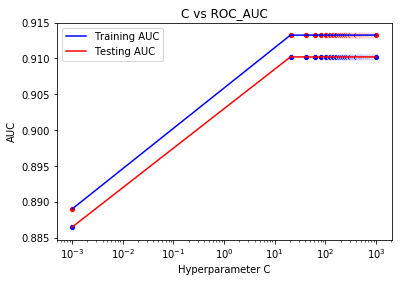

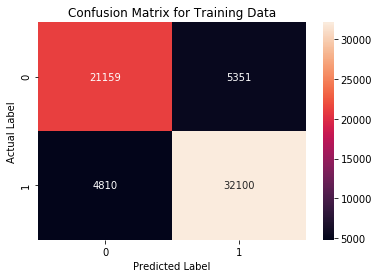

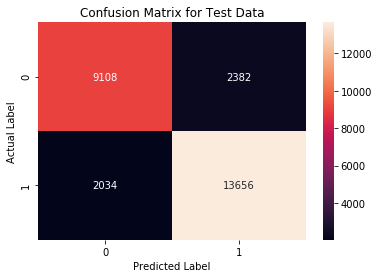

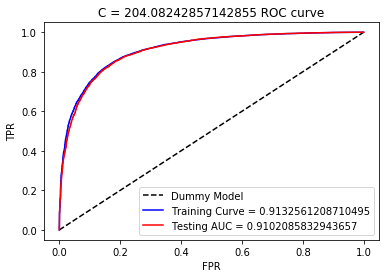

Wall time: 7min 32s


In [52]:
%%time
l1_aw2v_c, l1_aw2v_auc = get_best_hyperparam(X_train_aw2v, X_test_aw2v, y_train, y_test)

### [4.3.2] Finding the optimal C for avg_w2v with L2

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.01it/s]


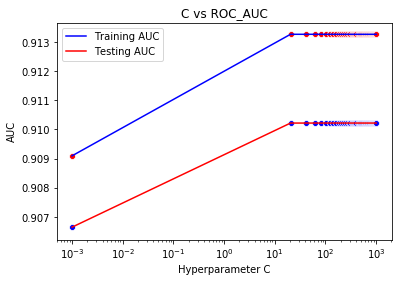

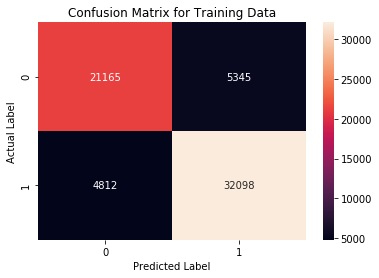

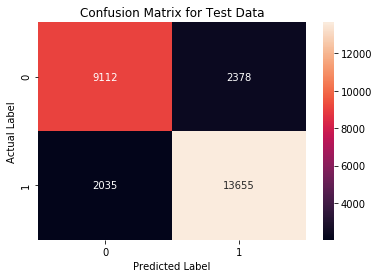

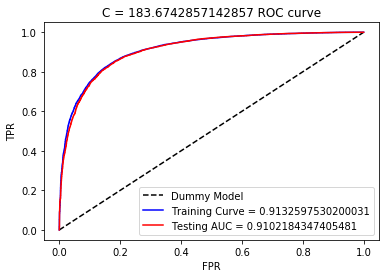

Wall time: 54.5 s


In [54]:
%%time
l2_aw2v_c, l2_aw2v_auc = get_best_hyperparam(X_train_aw2v, X_test_aw2v, y_train, y_test, pen="l2")

## [4.4] Applying Logistic Regression on tfidf_w2v

In [55]:
X_train_tfidf_w2v, X_test_tfidf_w2v, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [56]:
def compute_tfidf_w2v(model, w2v_model, list_of_reviews):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    w2v_words = list(w2v_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_reviews): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [57]:
X_train_tfidfw2v = compute_tfidf_w2v(tf_idf, w2v_model, list_of_reviews_train)

100%|████████████████████████████████████████████████████████████████████████████| 63420/63420 [37:43<00:00, 28.01it/s]


In [58]:
X_test_tfidfw2v = compute_tfidf_w2v(tf_idf, w2v_model, list_of_reviews_test)

100%|████████████████████████████████████████████████████████████████████████████| 27180/27180 [15:54<00:00, 28.47it/s]


### [4.4.1] Finding the optimal C with L1

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:04<00:00,  7.73s/it]


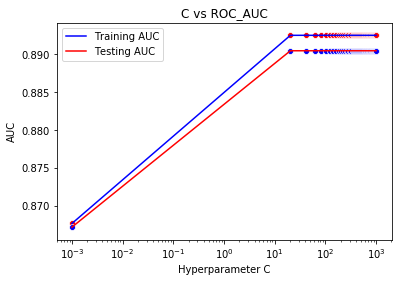

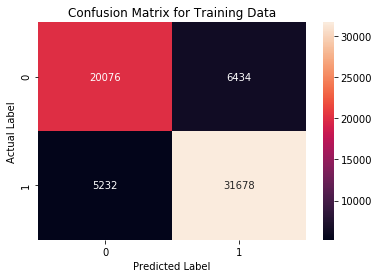

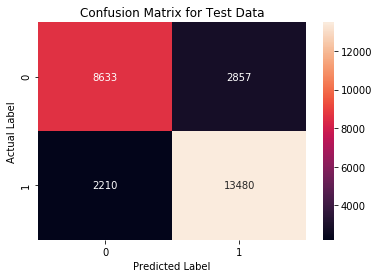

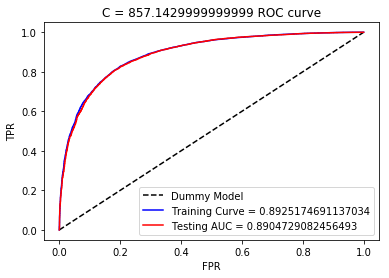

In [59]:
l1_tfidf_w2v_c, l1_tfidf_w2v_auc = get_best_hyperparam(X_train_tfidfw2v, X_test_tfidfw2v, y_train, y_test)

### [4.4.2] Finding the optimal C using L2

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.41s/it]


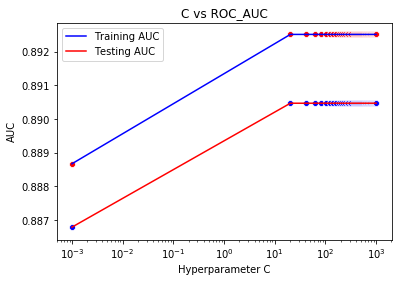

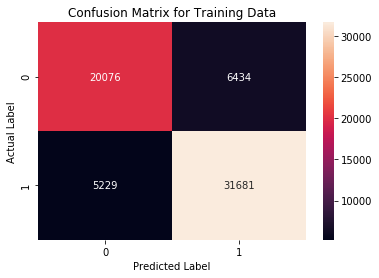

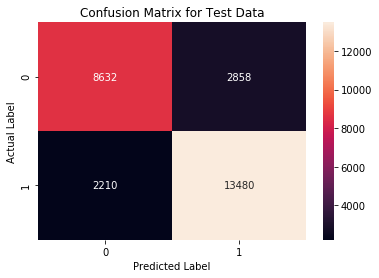

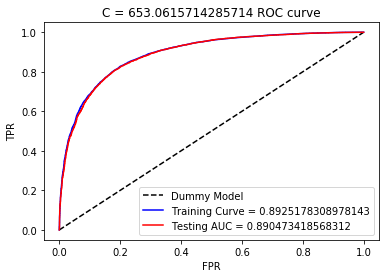

In [60]:
l2_tfidf_w2v_c, l2_tfidf_w2v_auc = get_best_hyperparam(X_train_tfidfw2v, X_test_tfidfw2v, y_train, y_test, pen="l2")

# Conclusion

In [62]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Regularizer", "Hyper parameter", "AUC"]
x.add_row(["BOW", "L1", l1_bow_c, l1_bow_auc])
x.add_row(["BOW", "L2", l2_bow_c, l2_bow_auc])
x.add_row(["TFIDF", "L1", l1_tfidf_c, l1_tfidf_auc])
x.add_row(["TFIDF", "L2", l2_tfidf_c, l2_tfidf_auc])
x.add_row(["Avg_w2v", "L1", l1_aw2v_c, l1_aw2v_auc])
x.add_row(["Avg_w2v", "L2", l2_aw2v_c, l2_aw2v_auc])
x.add_row(["TFIDF_w2v", "L1", l1_tfidf_w2v_c, l1_tfidf_w2v_auc])
x.add_row(["TFIDF_w2v", "L2", l2_tfidf_w2v_c, l2_tfidf_w2v_auc])
print(x)

+------------+-------------+--------------------+--------------------+
| Vectorizer | Regularizer |  Hyper parameter   |        AUC         |
+------------+-------------+--------------------+--------------------+
|    BOW     |      L1     | 734.6941428571428  | 0.9915608605471148 |
|    BOW     |      L2     | 102.04171428571428 | 0.9875170224540213 |
|   TFIDF    |      L1     | 938.7755714285713  | 0.9870851464698627 |
|   TFIDF    |      L2     | 244.89871428571428 | 0.991236498450266  |
|  Avg_w2v   |      L1     | 204.08242857142855 | 0.9102085832943657 |
|  Avg_w2v   |      L2     | 183.6742857142857  | 0.9102184347405481 |
| TFIDF_w2v  |      L1     | 857.1429999999999  | 0.8904729082456493 |
| TFIDF_w2v  |      L2     | 653.0615714285714  | 0.890473418568312  |
+------------+-------------+--------------------+--------------------+


## Summary:

- Since the train data was highly biased, I used upsampling to make a more balanced train data

- Post Data Loading and preprocessing with BeautifulSoup and other regex functions, I defined generalized functions to ensure ease of operations.

- To test the best hyperparameter, I used simple cv and generated a linear sequence of 50 numbers between 0.001 and 1000

- For regularization I used L1 and L2 regularizer and checked for multicollinear features by perturbation test on BOW

- Then I parsed the features which had percentage change vector above the threshold of 2.5 and zipped them in a list pcv and displayed the top 20 features. The sparsity of L1 was ~95 percent

- The L1 and L2 regularization was performed on all of the Vectorizers and summarised in a tabular format using PrettyTable 

- BOW and TFIDF are the 2 vectorizers with the highest ROC_AUC.